# Compare Network Performance
Load in the results from the model trainings, and evaluate their performance

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.schnetpack import run_model, load_model
from jcesr_ml.benchmark import load_benchmark_data
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm_notebook as tqdm
from ase.units import eV, Hartree
from time import perf_counter
from glob import glob
import pickle as pkl
import pandas as pd
import numpy as np
import torch
import json
import os

## Load in the Test Data
We are going to use it to validate our models

In [2]:
_, test_data = load_benchmark_data()

### Get Baseline Statistics of the Test Data
Things like the mean absolute devation, for understanding if the models are good

In [3]:
u0_mad = np.abs(test_data['u0'] - test_data['u0'].mean()).mean() * Hartree / eV
print('U0 MAD: {:.2f} eV'.format(u0_mad))

U0 MAD: 841.18 eV


In [4]:
g4mp2_mad = np.abs(test_data['g4mp2_0k'] - test_data['g4mp2_0k'].mean()).mean() * Hartree / eV
print('G4MP2 MAD: {:.2f} eV'.format(g4mp2_mad))

G4MP2 MAD: 840.68 eV


In [5]:
u0_mae_to_g4mp2 = np.abs(test_data['u0'] - test_data['g4mp2_0k']).mean() * Hartree / eV
print('B3LYP MAE for total energies: {:.2f} eV'.format(u0_mae_to_g4mp2))

B3LYP MAE for total energies: 12.43 eV


In [6]:
u0_mae_to_g4mp2_atom = np.abs(test_data['u0_atom'] - test_data['g4mp2_atom']).mean() * Hartree / eV
print('B3LYP MAE for formation energies: {:.2f} eV'.format(u0_mae_to_g4mp2_atom))

B3LYP MAE for formation energies: 0.20 eV


In [7]:
with open('baseline-stats.json', 'w') as fp:
    json.dump({
        'u0_mad': u0_mad,
        'g4mp2_mad': g4mp2_mad * Hartree / eV,
        'u0_total_energy_mae': u0_mae_to_g4mp2,
        'u0_atomization_mae': u0_mae_to_g4mp2_atom
    }, fp)

## Evaluate the `u0` Models
Make sure that our models are working as expected

### Plot the Learning as Function of Epoch
Look for anomalous behavior

1000 best loss after 35907 epochs was at 18399 epochs: 0.0001089241268346086
10000 best loss after 3545 epochs was at 1787 epochs: 1.0501355336600682e-05
117232 best loss after 471 epochs was at 439 epochs: 1.1718511012537742e-06


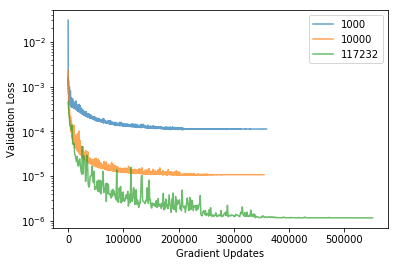

In [8]:
fig, ax = plt.subplots()

for f in sorted(glob(os.path.join('networks', 'u0', '*', 'log.csv'))):
    name = os.path.basename(os.path.dirname(f))
    log = pd.read_csv(f)
    print('{} best loss after {} epochs was at {} epochs:'.format(name, len(log), log['Validation loss'].idxmin()),
              log['Validation loss'].min())
    ax.semilogy(np.arange(len(log)) * float(name) / 100, log['Validation loss'], label=name, alpha=0.7)
    #ax.semilogy(log['Validation loss'], label=name)

ax.set_ylabel('Validation Loss')
ax.set_xlabel('Gradient Updates')
ax.legend()

### Plot MAE as function of Training Set Size
See whether it agrees with the paper

Get the sizes that have been tested

In [9]:
sizes = [int(os.path.basename(s)) for s in glob(os.path.join('networks', 'u0', '*')) if os.path.isdir(s)]
print('Found `u0` for {} training set sizes:'.format(len(sizes)), sizes)

Found `u0` for 3 training set sizes: [1000, 117232, 10000]


Test the model performance

In [10]:
%%time
results = []
for s in sizes:
    model = load_model('u0', s)
    
    # Get the MAE on the test set
    y_pred = run_model(model, test_data, 'xyz')
    results.append({
        'size': s,
        'mae': mean_absolute_error(y_pred, test_data['u0']) * Hartree / eV
    })

 69%|██████▉   | 9016/13026 [07:01<04:32, 14.73it/s]

In [11]:
results = pd.DataFrame(results).sort_values('size')
results

,mae,size
0,0.249384,1000
2,0.072446,10000
1,0.014264,117232


Plot the learning curve

In [12]:
schnet_paper = pd.DataFrame([[10043.498386561221, 0.054552926439280565], 
                             [24988.37317398674, 0.030443836515674838], 
                             [49717.89397295905, 0.02097245349947155],
                             [109068.73666195504, 0.013742234855898816]], columns=['size', 'mae'])

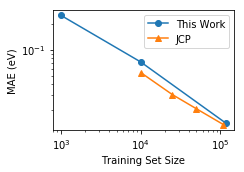

In [13]:
fig, ax = plt.subplots()

ax.loglog(results['size'], results['mae'], marker='o', label='This Work')
ax.loglog(schnet_paper['size'], schnet_paper['mae'], marker='^', label='JCP')

ax.set_xlabel('Training Set Size')
ax.set_ylabel('MAE (eV)')
ax.legend()

fig.set_size_inches(3.5, 2.5)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'u0-learning-curve.png'), dpi=320)

Save to disk for later use

In [14]:
results.to_json('uo-learning-curve.json')

## Compare the Different G4MP2 Models
Compare their accuracy as a function of training set size, and the learning rate as a number of epochs

In [15]:
models = sorted([x for x in os.listdir('networks') if x.startswith('g4mp2')], key=len)
print('Found {} architectures:'.format(len(models)), models)

Found 7 architectures: ['g4mp2', 'g4mp2-delta', 'g4mp2-charges', 'g4mp2-transfer', 'g4mp2-multitask', 'g4mp2-stacked-delta', 'g4mp2-charges-in-outnet']


### Learning Rate over Epochs
The idea is to test whether different models learn more quickly. They all use the same validation split, so the validation accuracies are comparable (except for multitask, which uses different outputs)

g4mp2 best loss after 469 epochs was at 445 epochs: 1.1808033797854004e-06
g4mp2-delta best loss after 483 epochs was at 469 epochs: 6.145835270378701e-08
g4mp2-charges best loss after 411 epochs was at 341 epochs: 1.2488637583969449e-06
g4mp2-transfer best loss after 269 epochs was at 222 epochs: 1.2131160528175815e-06
g4mp2-multitask best loss after 337 epochs was at 267 epochs: 3.531835279267048e-06
g4mp2-stacked-delta best loss after 377 epochs was at 200 epochs: 1.2684717406027666e-06
g4mp2-charges-in-outnet best loss after 497 epochs was at 450 epochs: 1.2189452936599646e-06


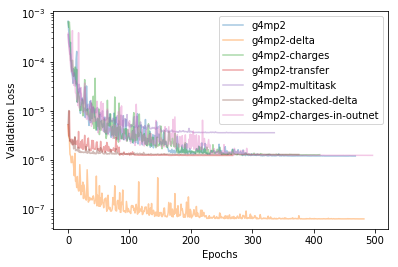

In [16]:
fig, ax = plt.subplots()
size = 117232

# Plot each directory
for name in models:
    try:
        log = pd.read_csv(os.path.join('networks', name, str(size), 'log.csv'))
        print('{} best loss after {} epochs was at {} epochs:'.format(name, len(log), log['Validation loss'].idxmin()),
              log['Validation loss'].min())
        ax.semilogy(log['Validation loss'], label=name, alpha=0.4)
    except FileNotFoundError as e:
        print('File not found for: ' + name)
    
ax.set_ylabel('Validation Loss')
ax.set_xlabel('Epochs')
ax.legend()

## Plot MAE as Function of Training Set Size
Gather the MAE as a function of training set size for each model type

In [17]:
results = []
for name in models:
    sizes = [int(os.path.basename(s)) for s in glob(os.path.join('networks', name, '*')) if os.path.isdir(s)]
    for s in sizes:
        # Load in the model
        model = load_model(name, s)
        
        # Display warning if not converged
        converged = True
        if not os.path.isfile(os.path.join('networks', name, str(s), 'finished')):
            print('Warning {} not converged for size {}'.format(name, s))
            converged = False

        # Get the MAE on the test set
        run_time = perf_counter()
        y_pred = run_model(model, test_data, 'xyz', ['u0', 'atomic_charges'])
        run_time = perf_counter() - run_time
        if len(y_pred.shape) == 2:
            y_pred = y_pred[:, 0]  # G4MP2 energy is always the first column
        results.append({
            'size': s,
            'name': name,
            'run_time': run_time,
            'mae': mean_absolute_error(y_pred, test_data['g4mp2_0k']) * Hartree / eV,
            'converged': converged,
        })
        
        test_data['ypred-{}-{}'.format(name, s)] = y_pred

 78%|███████▊  | 10114/13026 [08:15<03:09, 15.35it/s]

In [18]:
results = pd.DataFrame(results)

In [19]:
results

,converged,mae,name,run_time,size
0,True,0.238957,g4mp2,649.026785,1000
1,True,0.014916,g4mp2,645.036228,117232
2,True,0.065198,g4mp2,657.160186,10000
3,True,0.030114,g4mp2-delta,665.613616,1000
4,True,0.004455,g4mp2-delta,646.861267,117232
5,True,0.015881,g4mp2-delta,646.332979,10000
6,False,0.250619,g4mp2-charges,635.860621,1000
7,True,0.014799,g4mp2-charges,634.996836,117232
8,True,0.068879,g4mp2-charges,647.063032,10000
9,True,0.084842,g4mp2-transfer,638.611092,1000


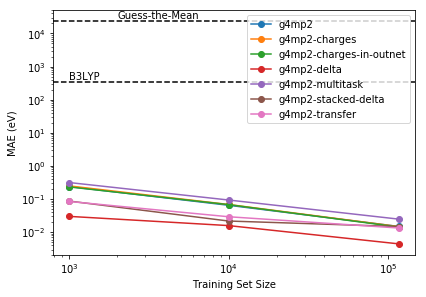

In [20]:
fig, ax = plt.subplots()

for gid, group in results.groupby('name'):
    group = group.sort_values('size')
    
    ax.loglog(group['size'], group['mae'], label=gid, marker='o')
    
# Plot the baseline accuracies
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [g4mp2_mad * Hartree / eV]*2, 'k--')
ax.text(2000, g4mp2_mad * Hartree / eV * 1.2, 'Guess-the-Mean')
ax.plot(ax.get_xlim(), [u0_mae_to_g4mp2 * Hartree / eV]*2, 'k--')
ax.text(1000, u0_mae_to_g4mp2 * Hartree / eV * 1.2, 'B3LYP')

    
ax.legend(ncol=1, loc='upper right')

ax.set_ylabel('MAE (eV)')
ax.set_xlabel('Training Set Size')

fig.set_size_inches(6.5, 4.5)
fig.savefig(os.path.join('figures', 'g4mp2-learning-curve.png'), dpi=320)

In [21]:
results.to_json('g4mp2-models.json')

Save individual predictions

In [22]:
test_data.to_csv('schnet_predictions.csv.gz', compression='gzip', index=False)